# Processing, analysis, and visualization pipeline for detecting and quantifying the largest peak following events in fMRI timeseries data 

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn
import os
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
import scipy.fftpack
from sklearn.linear_model import LinearRegression
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta  
from scipy.signal import find_peaks, peak_prominences, peak_widths, find_peaks_cwt, butter, lfilter, freqz, sosfilt, welch, filtfilt, lfilter_zi, sosfilt_zi, sosfiltfilt
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plot formatting helper function

In [22]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)

        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)
            
        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('project-directory-path') # load project object
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object

In [23]:
def get_data_from_group(prj, group, region):
    new_prj = prj(2, 'subproject-folder-name', 'session-folder-name', group, ext='.xlsx')
    df = pd.DataFrame()
    for i, finfo in new_prj:
        df[i] = pd.read_excel(finfo.Abspath)[region]
    return df

# function to correct baseline drift by subtracting OLS line of best fit

In [24]:
def flatten_data(y):
    for name in y.columns:
        X = np.array(range(len(y[name]))).reshape(-1,1)
        Y = y[name].values.reshape(-1,1)
        lr = LinearRegression().fit(X, Y)  # perform linear regression


        slope = lr.coef_[0][0]
        y_int = lr.intercept_[0]

        for i in range(len(y[name])):
            y[name][i] = y[name][i] - (slope * i + y_int)

# function to baseline correct, baseline subtract, plot group data mean +/- SEM for trial epochs relative to event timing, and export data to Excel
## this particular function plots 2 groups (e.g. experimental vs control group)
## Change veriables to fit your paradigm as needed here or when calling function

In [25]:
def plot_groups_data(prj, opto_group_a, eyfp_group_a, region, figsize=[7.5,7.5], label_size=60, err=1, title_size=60, 
                     tick_size=50, ylabel='CBV change (%)', xlabel='', color1='red', color2='grey', bl_end=19, n_tick_b=20,
                     n_tick_a = 1, ylim = [-5,5], stim=[[20, 60],10], linewidth = 5):
    
    data_opto_a = get_data_from_group(prj, opto_group_a, region)
    data_opto_raw = get_data_from_group(prj, opto_group_a, region)
    flatten_data(data_opto_a)

    dfup_sub = data_opto_a.iloc[0:bl_end]

    data_opto_a = data_opto_a - dfup_sub.mean()
    data_opto_a = data_opto_a*100
       
    data_eyfp_a = get_data_from_group(prj, eyfp_group_a, region)
    data_eyfp_raw = get_data_from_group(prj, eyfp_group_a, region)
    flatten_data(data_eyfp_a)

    dfup_sube = data_eyfp_a.iloc[0:bl_end]
                                
    data_eyfp_a = data_eyfp_a - dfup_sube.mean()
    data_eyfp_a = data_eyfp_a*100
    
    data_opto_a.to_excel('{}_{}.xlsx'.format(opto_group_a, region), index=None, header=None)
    data_eyfp_a.to_excel('{}_{}.xlsx'.format(eyfp_group_a, region), index=None, header=None)
        
    ax = tsplot(data_eyfp_a, color = color2, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, linewidth=linewidth, ylim=ylim)
    ax = tsplot(data_opto_a, color = color1, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, linewidth=linewidth, ylim=ylim, add_plot=ax)

    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ax[1].set_xlim(right = data_opto_a.shape[0])
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ylim_neg = ax[1].get_ylim()
    if stim:
        for p in stim[0]:
            ax[1].add_patch(patches.Rectangle((p, ylim_neg[0]), stim[1], abs(ylim_neg[0])+abs(ylim_neg[1]),color='g', alpha=0.09))
    
    return ax

(<matplotlib.figure.Figure at 0x7fd5343de150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd53402ff50>)

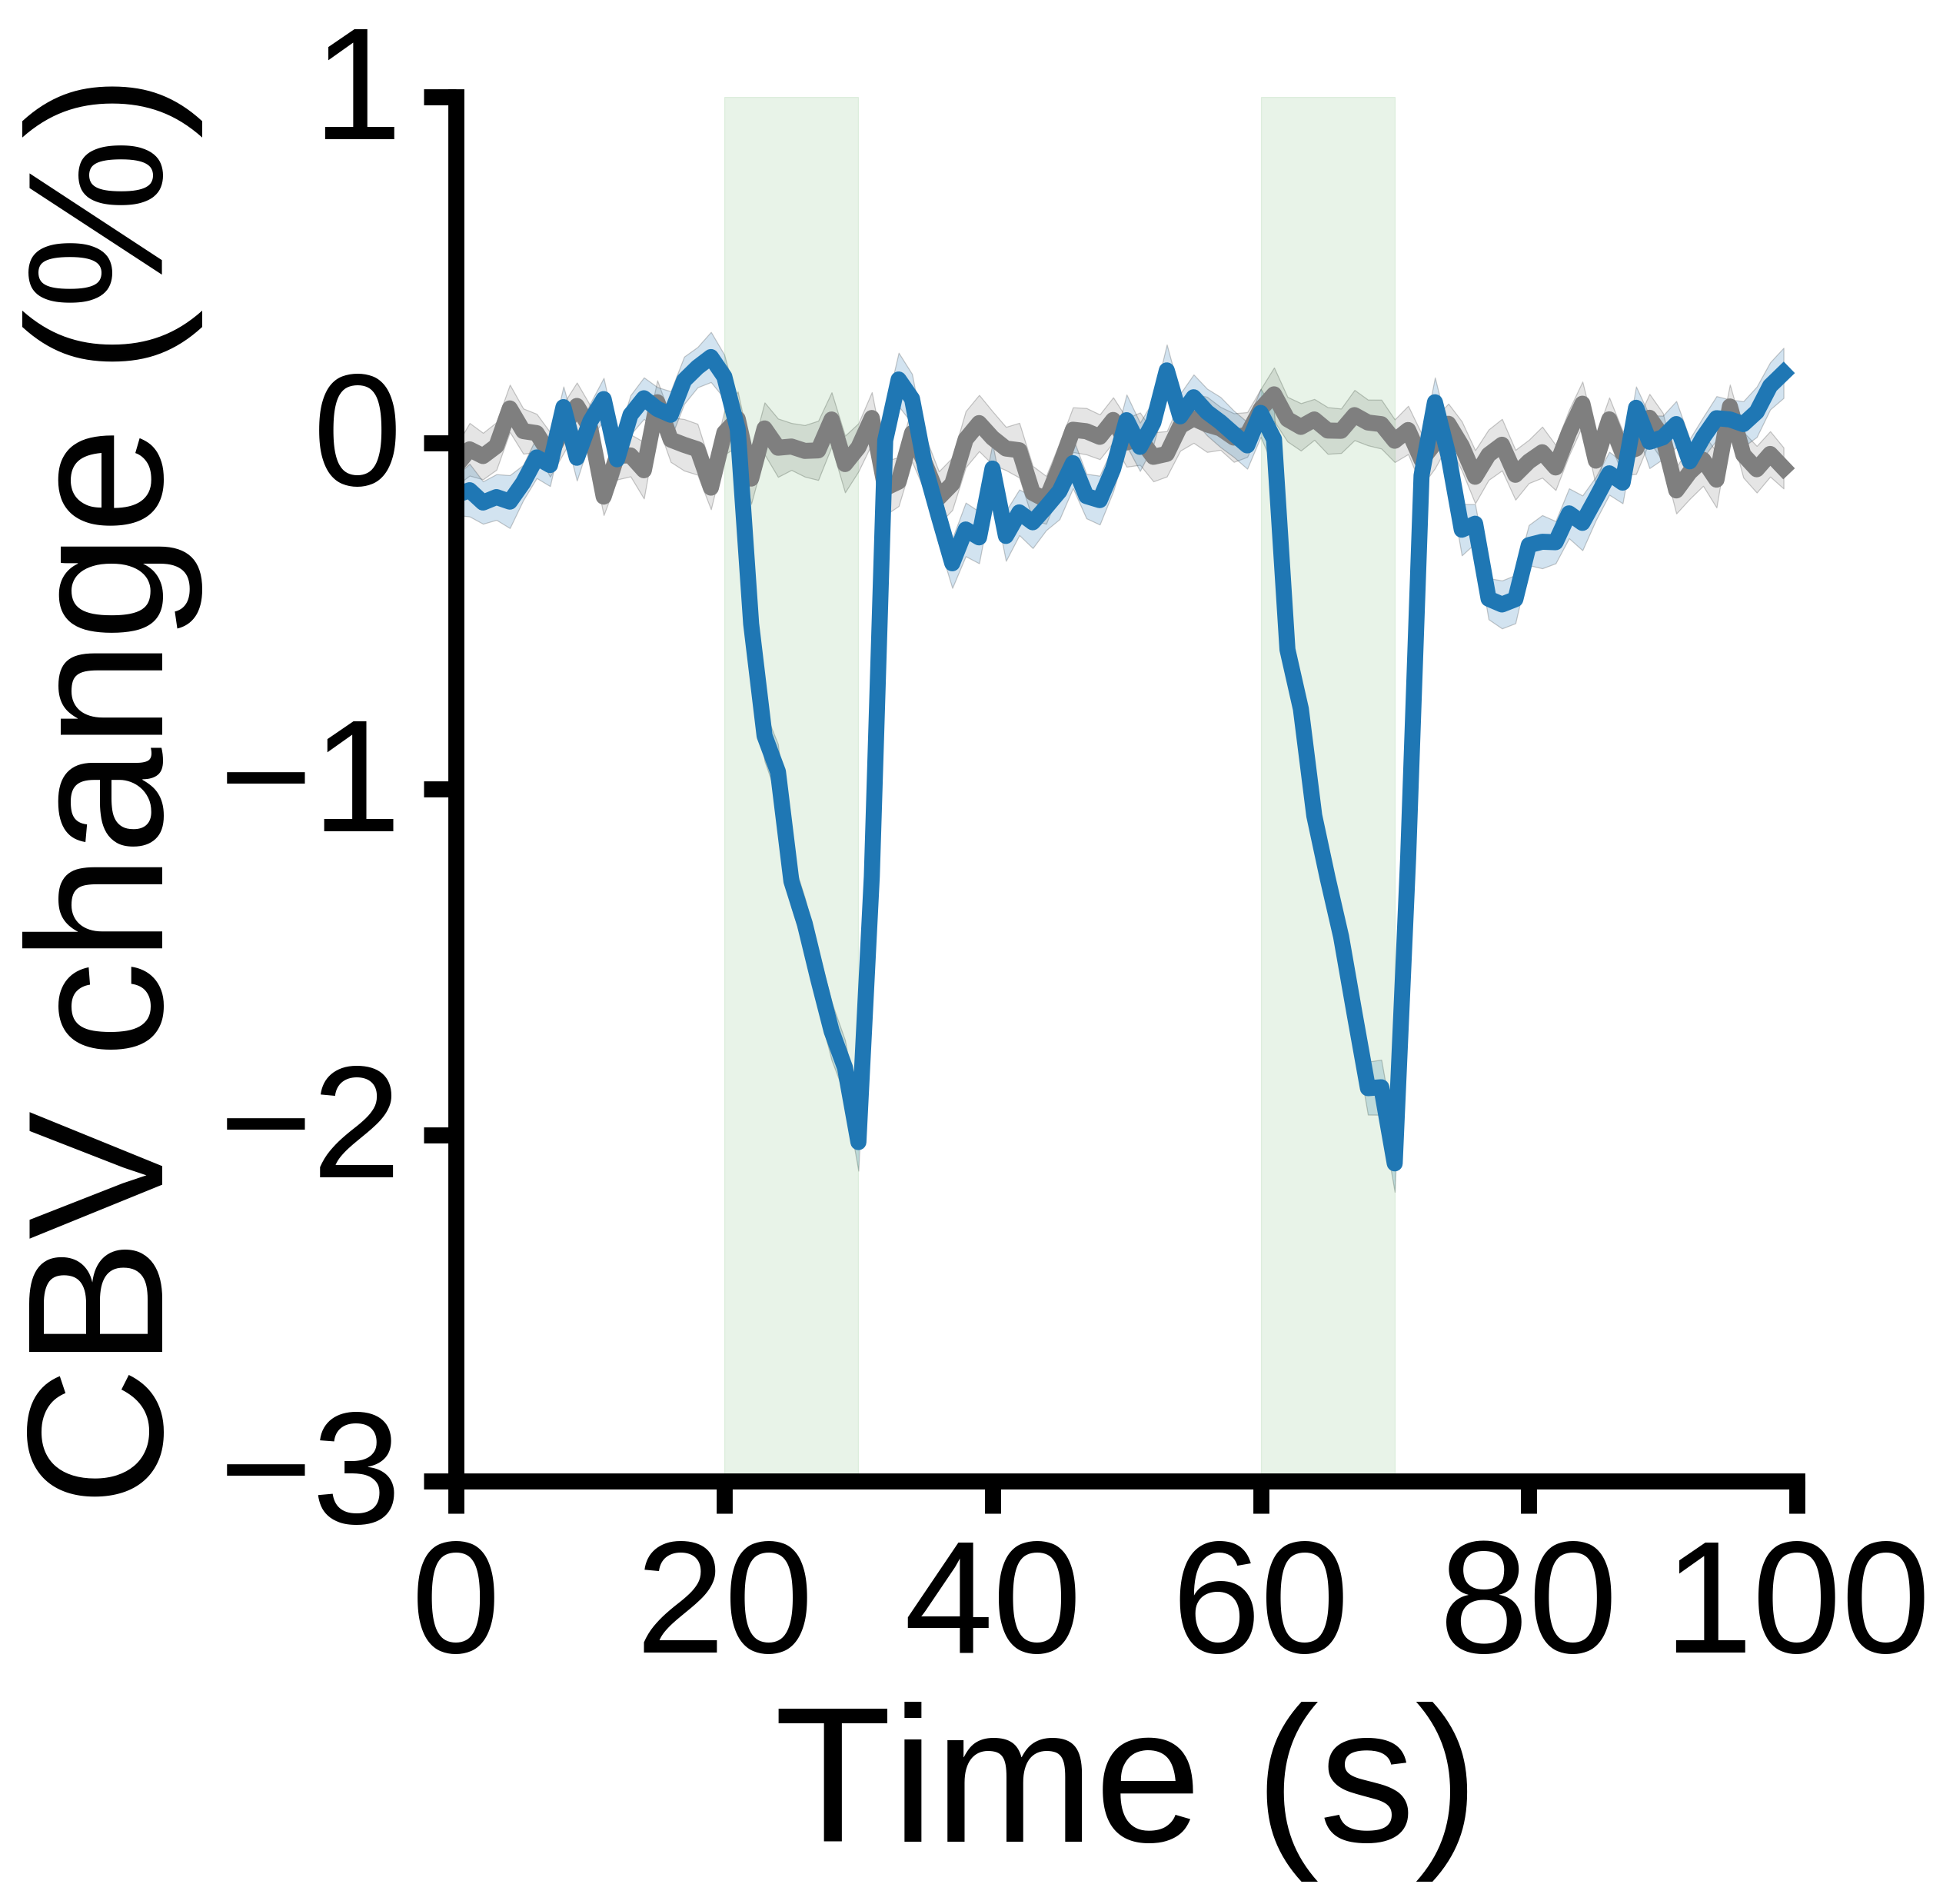

In [26]:
plot_groups_data(prj, 'first_group_name', 'second_group-name' , 'session-name', n_tick_a = 1, ylim = [-3,1], color1 = 'tab:blue', color2 = 'tab:grey')

# Function to cut each scan into single epochs and align them for peak analysis

## adjust epoch start, end, and number (for loop range) to fit your paradigm

In [28]:
def extract_evoked(data_stim):
    epoch_data = []
    for i in range(2):
        epoch_start = 0+i*40
        epoch_end = 59+i*40
        epoch_ts = data_stim.loc[epoch_start:epoch_end, :].T.values

        epoch_data.append(epoch_ts.T)
    epoch_data = np.concatenate(epoch_data, axis=1)

    epoch_data = pd.DataFrame(epoch_data)
    return epoch_data

# function to find the location of the largest peak following stimulus presentation on the group level, then extract the value at that location for each trial, plot these peaks and export the data to excel

## note that most parameters should be set when calling the function. Group to analyze peak location is always taken from the reference_group (experimental)

In [29]:
def analyze_epoch(prj, opto_group, reference_group, region, sign, stim_start, stim_end, avg_start, avg_end):
    data_opto_a = get_data_from_group(prj, opto_group, region)
    flatten_data(data_opto_a)
    dfup_sub = data_opto_a.iloc[0:stim_start-2]
    data_opto_a = data_opto_a - dfup_sub.mean()
    df = extract_evoked (data_opto_a) 
    df = df*100
    
    data_ChR2 = get_data_from_group(prj, reference_group, region)
    flatten_data(data_ChR2)
    dfup_ChR2 = data_ChR2.iloc[0:stim_start-2]
    data_ChR2 = data_ChR2 - dfup_ChR2.mean()
    df_ChR2 = extract_evoked (data_ChR2) 
    df_ChR2 = df_ChR2*sign
    
    dmean = df_ChR2.mean(axis=1)

    dmean = pd.DataFrame(dmean)
    dmean = dmean[0].tolist()

    peakloc = dmean.index(max(dmean[stim_start:stim_end]))
    
    dfup = df
    
    ax = dfup.plot(cmap='summer',legend=False, figsize= (9,9), linewidth=0.5)
    ax.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    newdf = DataFrame()
    
    csvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in dfup.columns:
        list = dfup[name].tolist();
               
        peakx=peakloc
        peaky=sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])
        
        newcol = []
        newcol = newcol + [NaN]*(dfup.count()[0]);
        
        newcol[peakx] = peaky

        newdf[int(name)] = newcol
        csvdf = csvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);

    csvdf.to_csv('{}_{}.csv'.format(opto_group, region))
    a = newdf.plot(marker= 7, color='black', legend=False, ax=ax)
    ax.add_patch(patches.Rectangle((peakloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
    pyplot.show()

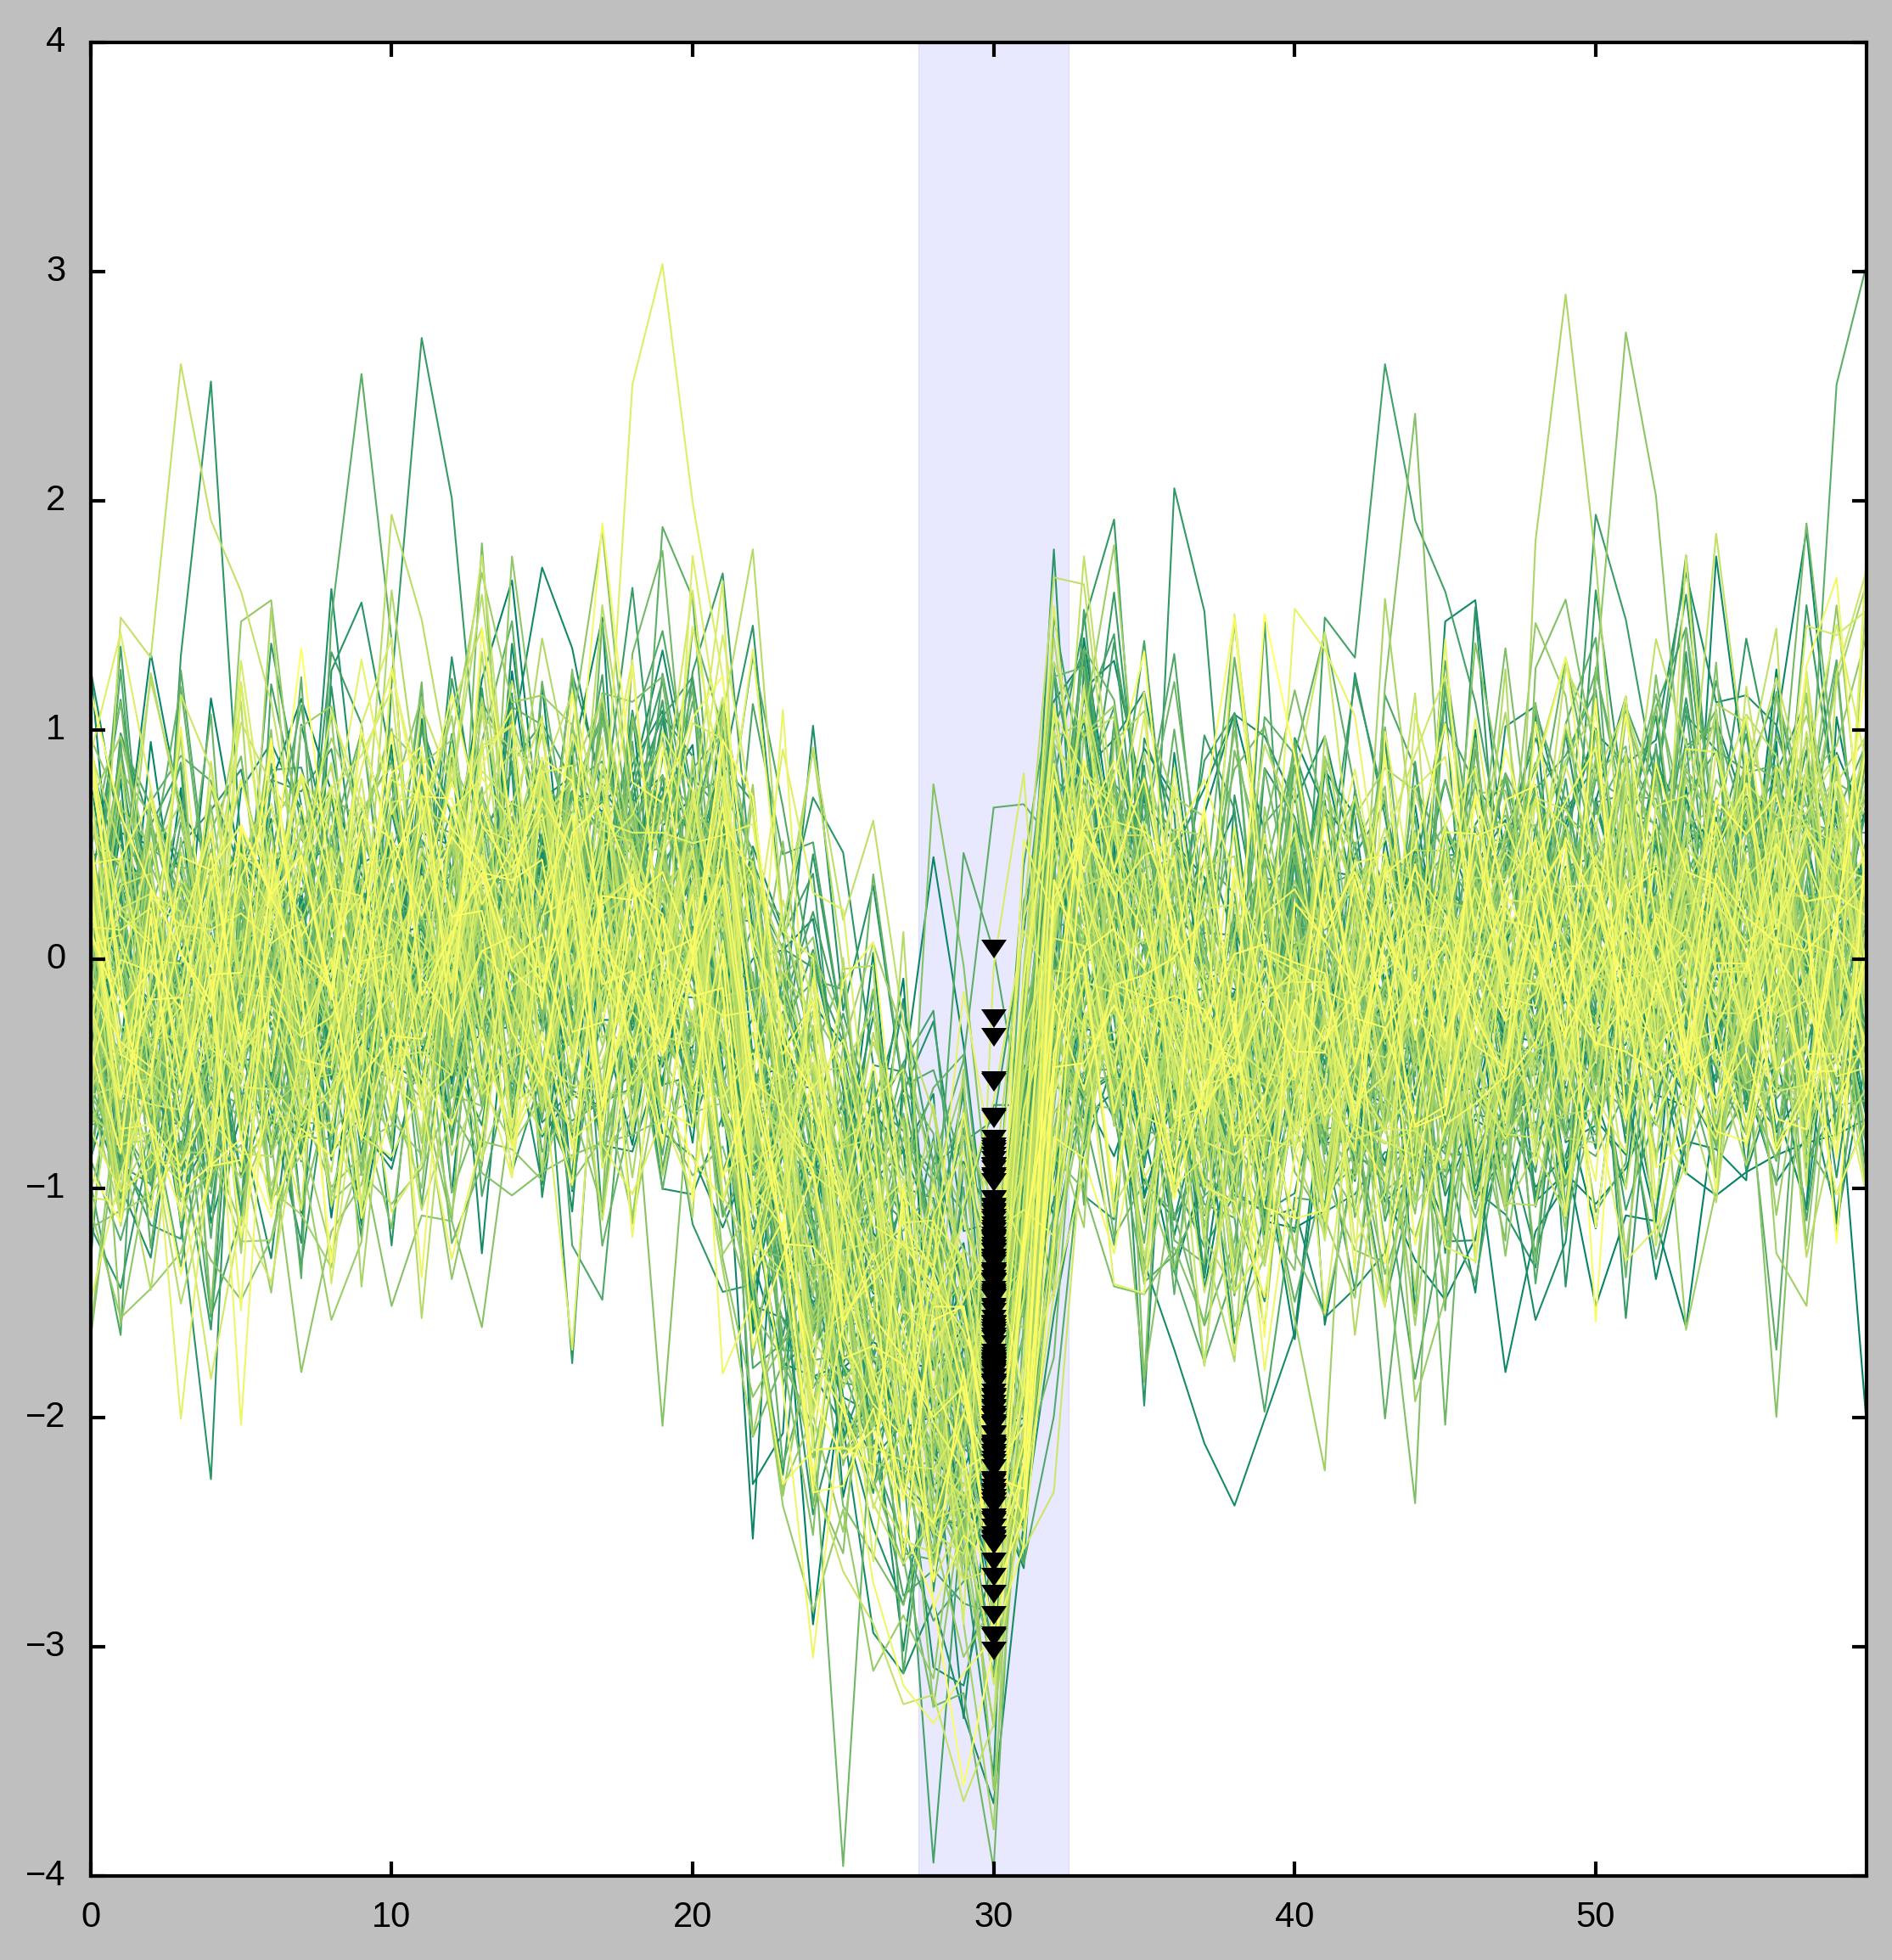

In [32]:
analyze_epoch(prj, 'target-group-name', 'reference-group-name', 'session-name', sign = -1, stim_start = 21, stim_end = 35, avg_start = -2, avg_end = 2)